# Visualising Withdrawals

The withdrawals data provides lists competitors who have withdrawn on a particular stage. Perhaps the simplest visualisation is a simple interactive that lets us select a stage and then display the comperitors who withdraw on that stage. An extra `all` option allows us to display all the withdrawals. 

In [1]:
from dakar_rallydj.getter import get_withdrawals
# Optionally specify category (A. F, K, M)
withdrawals_df, withdrawn_competitors_df, withdrawn_teams_df = get_withdrawals()

One of the things we note from the withdrawals data is that we don't know what classes the withdrawals relate to:

In [2]:
withdrawals_df.head()

,stage,bib,reason,_category
0,2,223,1,A
1,3,225,1,A
2,3,306,1,A
3,3,313,1,A
4,3,355,1,A


So let's add in some additional metadata so we can filter on classes:

In [14]:
from dakar_rallydj.getter import get_groups,  get_clazz, derive_clazz_metadata

groups_df = get_groups()
clazz_df = get_clazz()

clazz_metadata_df = derive_clazz_metadata(withdrawn_teams_df, clazz_df, groups_df)

clazz_metadata_df.head()

,team.bib,reference,categoryClazz,clazz_label,tinyLabel,label,color,group_label
0,202,2025-A-T1-+,2025-A-T1,T1+: Prototype Cross-Country Cars 4x4,ULT,T1,#EBBC4E,Ultimate
1,206,2025-A-T1-+,2025-A-T1,T1+: Prototype Cross-Country Cars 4x4,ULT,T1,#EBBC4E,Ultimate
2,208,2025-A-T1-+,2025-A-T1,T1+: Prototype Cross-Country Cars 4x4,ULT,T1,#EBBC4E,Ultimate
3,213,2025-A-T1-2,2025-A-T1,T1.2 Prototype Cross-Country Cars 4x2,ULT,T1,#EBBC4E,Ultimate
4,219,2025-A-T1-+,2025-A-T1,T1+: Prototype Cross-Country Cars 4x4,ULT,T1,#EBBC4E,Ultimate


In [15]:
clazz_metadata_df["tinyLabel"].unique()

array(['ULT', 'CHG', 'SSV', 'TRK'], dtype=object)

We can now merge the withdrawal table with the metadata table:

In [16]:
import pandas as pd

withdrawals_df = pd.merge(withdrawals_df, clazz_metadata_df.rename(columns={"team.bib":"bib"}), on="bib")

withdrawals_df.head()

,stage,bib,reason,_category,reference_x,categoryClazz_x,clazz_label_x,tinyLabel_x,label_x,color_x,...,label_y,color_y,group_label_y,reference,categoryClazz,clazz_label,tinyLabel,label,color,group_label
0,2,223,1,A,2025-A-T1-2,2025-A-T1,T1.2 Prototype Cross-Country Cars 4x2,ULT,T1,#EBBC4E,...,T1,#EBBC4E,Ultimate,2025-A-T1-2,2025-A-T1,T1.2 Prototype Cross-Country Cars 4x2,ULT,T1,#EBBC4E,Ultimate
1,3,225,1,A,2025-A-T1-+,2025-A-T1,T1+: Prototype Cross-Country Cars 4x4,ULT,T1,#EBBC4E,...,T1,#EBBC4E,Ultimate,2025-A-T1-+,2025-A-T1,T1+: Prototype Cross-Country Cars 4x4,ULT,T1,#EBBC4E,Ultimate
2,3,306,1,A,2025-A-T3-1,2025-A-T3,T3.1: Lightweight Prototype Cross-Country,CHG,T3,#E04E39,...,T3,#E04E39,Challenger,2025-A-T3-1,2025-A-T3,T3.1: Lightweight Prototype Cross-Country,CHG,T3,#E04E39,Challenger
3,3,313,1,A,2025-A-T3-1,2025-A-T3,T3.1: Lightweight Prototype Cross-Country,CHG,T3,#E04E39,...,T3,#E04E39,Challenger,2025-A-T3-1,2025-A-T3,T3.1: Lightweight Prototype Cross-Country,CHG,T3,#E04E39,Challenger
4,3,355,1,A,2025-A-T3-1,2025-A-T3,T3.1: Lightweight Prototype Cross-Country,CHG,T3,#E04E39,...,T3,#E04E39,Challenger,2025-A-T3-1,2025-A-T3,T3.1: Lightweight Prototype Cross-Country,CHG,T3,#E04E39,Challenger


We can do some counting to analyse withdrawals by category:

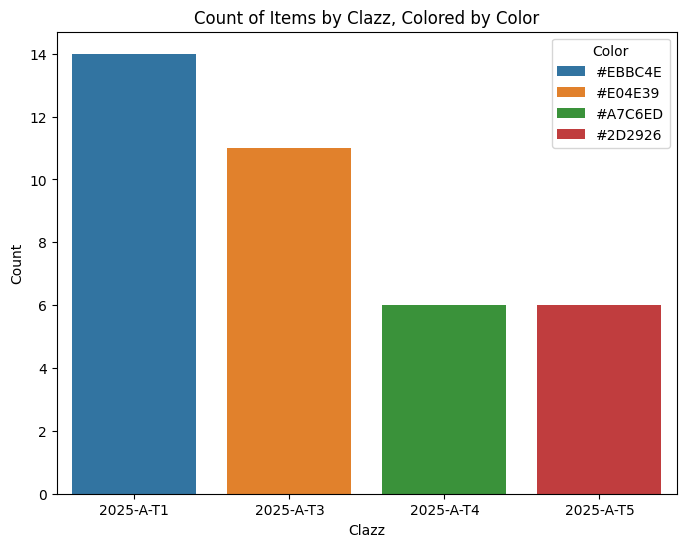

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=withdrawals_df, x="categoryClazz",
              hue="color")

# Add labels and title
plt.xlabel("Clazz")
plt.ylabel("Count")
plt.title("Count of Items by Clazz, Colored by Color")

# Show plot
plt.legend(title="Color");

But that doesn't play nicely with the colour mapping. To get better control over the colours, we can use a *Grammar of Graphics* approach:

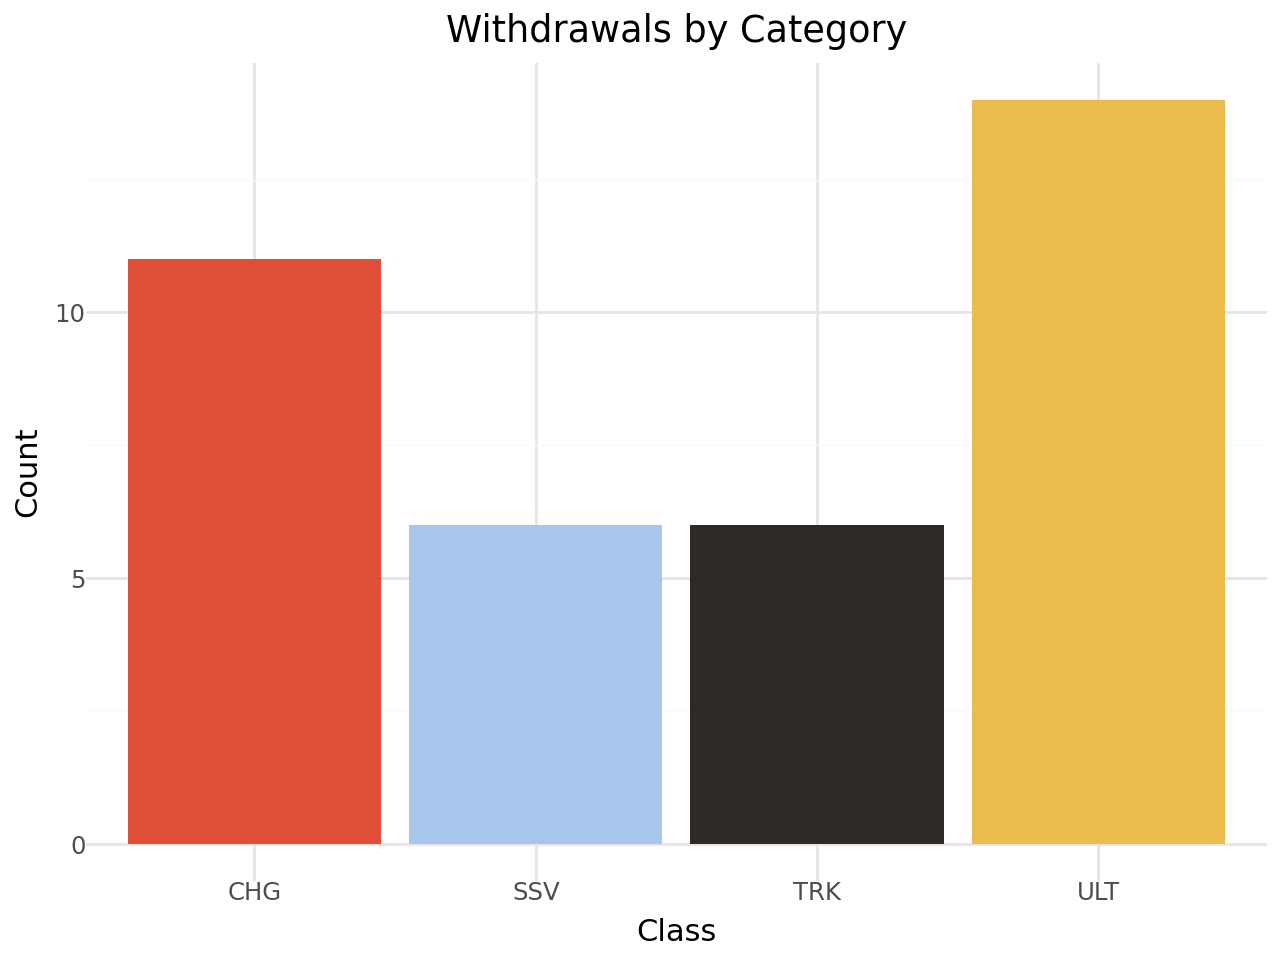

In [18]:
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, theme, scale_fill_manual

color_map = dict(
    zip(withdrawals_df['tinyLabel'].unique(), withdrawals_df['color'].unique()))


g = (
    ggplot(withdrawals_df, aes(x="tinyLabel", fill="tinyLabel"))
    + geom_bar()
    + theme_minimal()
    + labs(
        title="Withdrawals by Category",
        x="Class",
        y="Count",
        fill="Color"
    )
    + scale_fill_manual(values=color_map)
    + theme(legend_position='none')
)

g

*Recall that these results are just for the specified categories, and by default we have only loaded in data for the `auto` (`A`) category.*

How about withdrawals by stage?

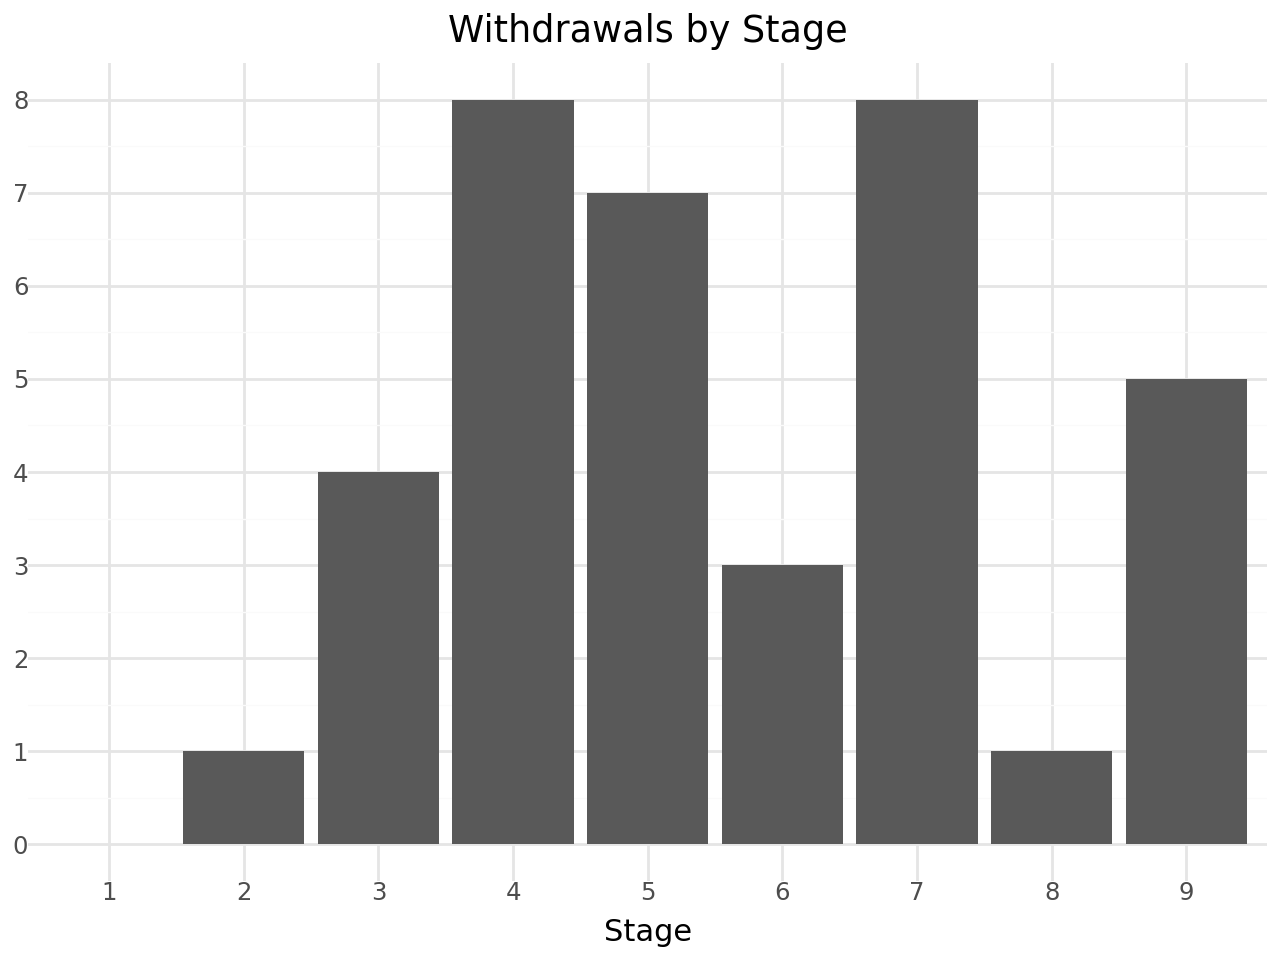

In [20]:
from plotnine import scale_x_discrete, scale_y_continuous

(
    ggplot(withdrawals_df, aes(x='stage'))
    # Dodge groups bars
    # We also want the bars to have a preserved width
    + geom_bar()
    + theme_minimal()
    + scale_x_discrete(
        # Treat 'stage' as a categorical variable
        # while keeping the order of integers
        # Ensure 'stage' is treated in order
        limits=sorted(range(1, withdrawals_df['stage'].max()+1))
    )
    + scale_y_continuous(
        # Force integer ticks for the y-axis
        breaks=lambda l: range(0, int(l[-1])+1, 1)
    )
    + theme_minimal()
    + labs(
        title="Withdrawals by Stage",
        x="Stage",
        y="",
        fill="Class"
    )
)

Or withdrawals by stage and class?

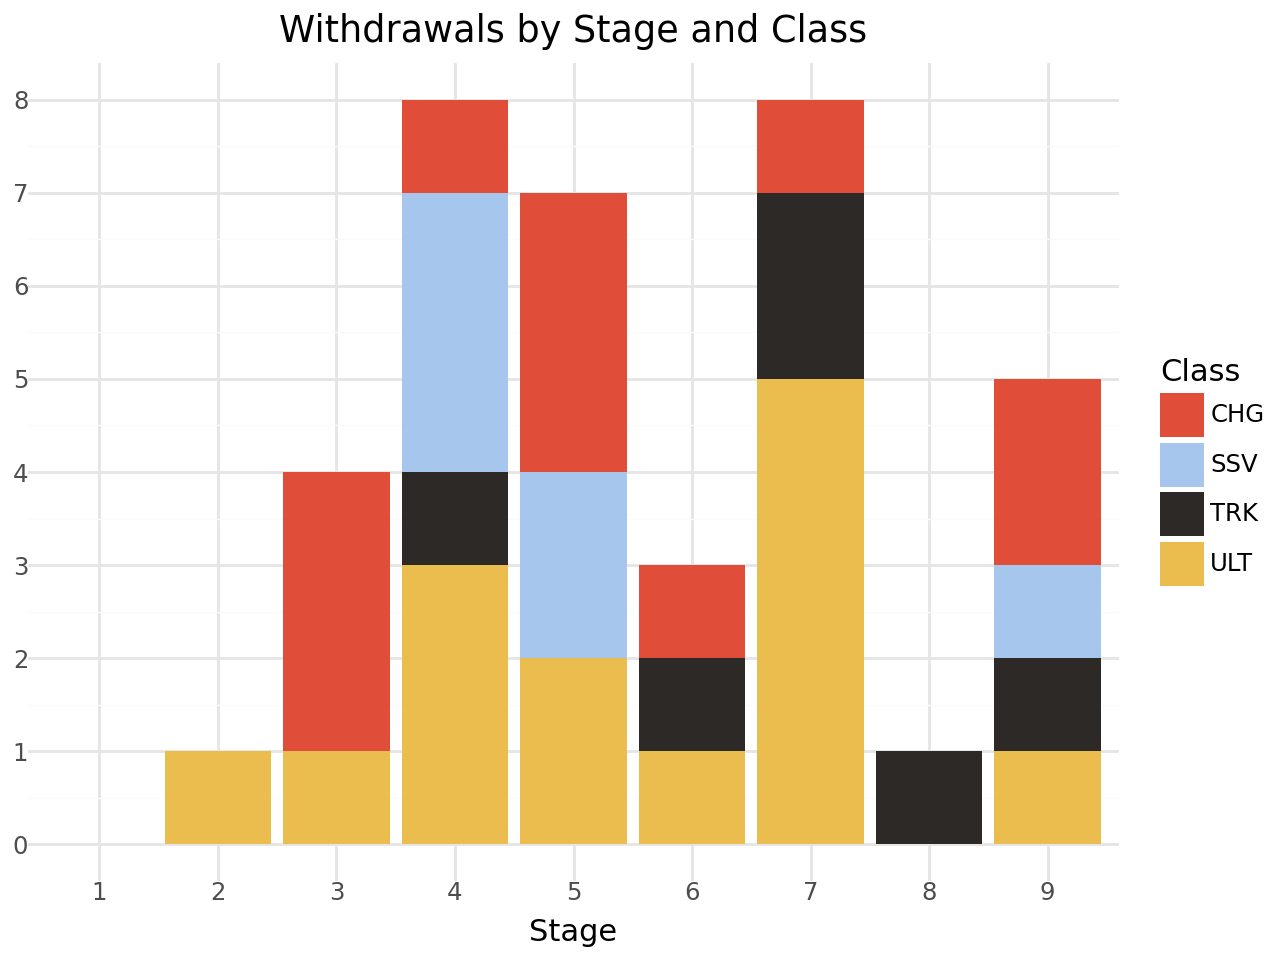

In [21]:

(
    ggplot(withdrawals_df, aes(x='stage', fill='tinyLabel', group='tinyLabel'))
    # Stack group bars
    + geom_bar(position='stack')
    + theme_minimal()
    + scale_x_discrete(
        # Treat 'stage' as a categorical variable
        # while keeping the order of integers
        # Ensure 'stage' is treated in order
        limits=sorted(range(1, withdrawals_df['stage'].max()+1))
    )
    # The color is given in the data
    + scale_fill_manual(values=color_map)
    + scale_y_continuous(
        # Force integer ticks for the y-axis
        breaks=lambda l: range(0, int(l[-1])+1, 1)
    )
    + theme_minimal()
    + labs(
        title="Withdrawals by Stage and Class",
        x="Stage",
        y="",
        fill="Class"
    )
)

I find that sort of chart quite confusing. I find it much more readable if we *dodge* the bars rather than *stack* them:

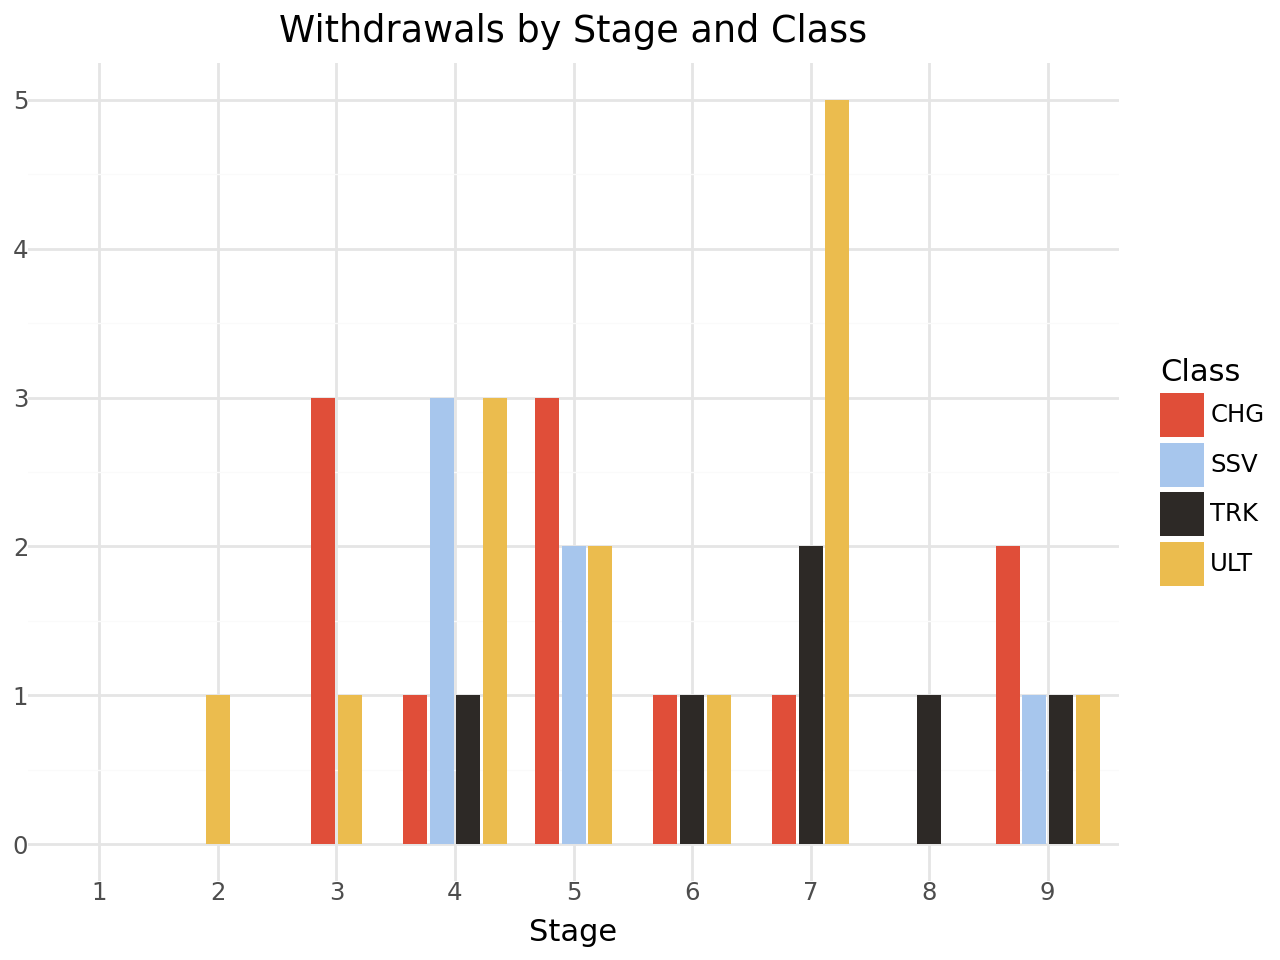

In [19]:
from plotnine import position_dodge2

(
    ggplot(withdrawals_df, aes(x='stage', fill='tinyLabel', group='tinyLabel'))
    # Dodge groups bars
    # We also want the bars to have a preserved width
    + geom_bar(position=position_dodge2(width=0.9, preserve="single"))
    + theme_minimal()
    + scale_x_discrete(
        # Treat 'stage' as a categorical variable
        # while keeping the order of integers
        # Ensure 'stage' is treated in order
        limits=sorted(range(1, withdrawals_df['stage'].max()+1))
    )
    # The color is given in the data
    + scale_fill_manual(values=color_map)
    + scale_y_continuous(
        # Force integer ticks for the y-axis
        breaks=lambda l: range(0, int(l[-1])+1, 1)
    )
    + theme_minimal()
    + labs(
        title="Withdrawals by Stage and Class",
        x="Stage",
        y="",
        fill="Class"
    )
)